In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Importamos los datos

In [20]:
df = pd.read_excel('../data/Clase 3 - Gamma Signal.xlsx')
df['Class'] = df['Class'].apply(lambda x: 1 if x == 'g' else 0)

# Vemos los primeros registros

In [12]:
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist Class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [4]:
df.describe()

fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000  
mean      -4.331745     10.545545      0.249726     27.645707    193.818026  
std       59.206062     51.000118     20.827439     26.103621     74.731787  
min     -457.916100   -331.780000   -205.894700      0.000000      1.282600  
25%      -20.586550    -12.842775    -10.849375      5.547925    142.492250  
50%        4.013050     15.314100      0.666200     17.679500    191.851450  
75%       24.063700     35.837800     10.946425     45.883550    240.563825  
max      575.240700    238.321000    179.851000     90.000000    495.561000

Vemos que los datos no están estandarizados, por lo que debemos hacerlo

In [30]:
X = df.drop(columns=['Class'])
y = df['Class']
X_scaler = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaler, columns=X.columns)
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns).reset_index(drop=True)

Se revisarán los datos con un scatter plot

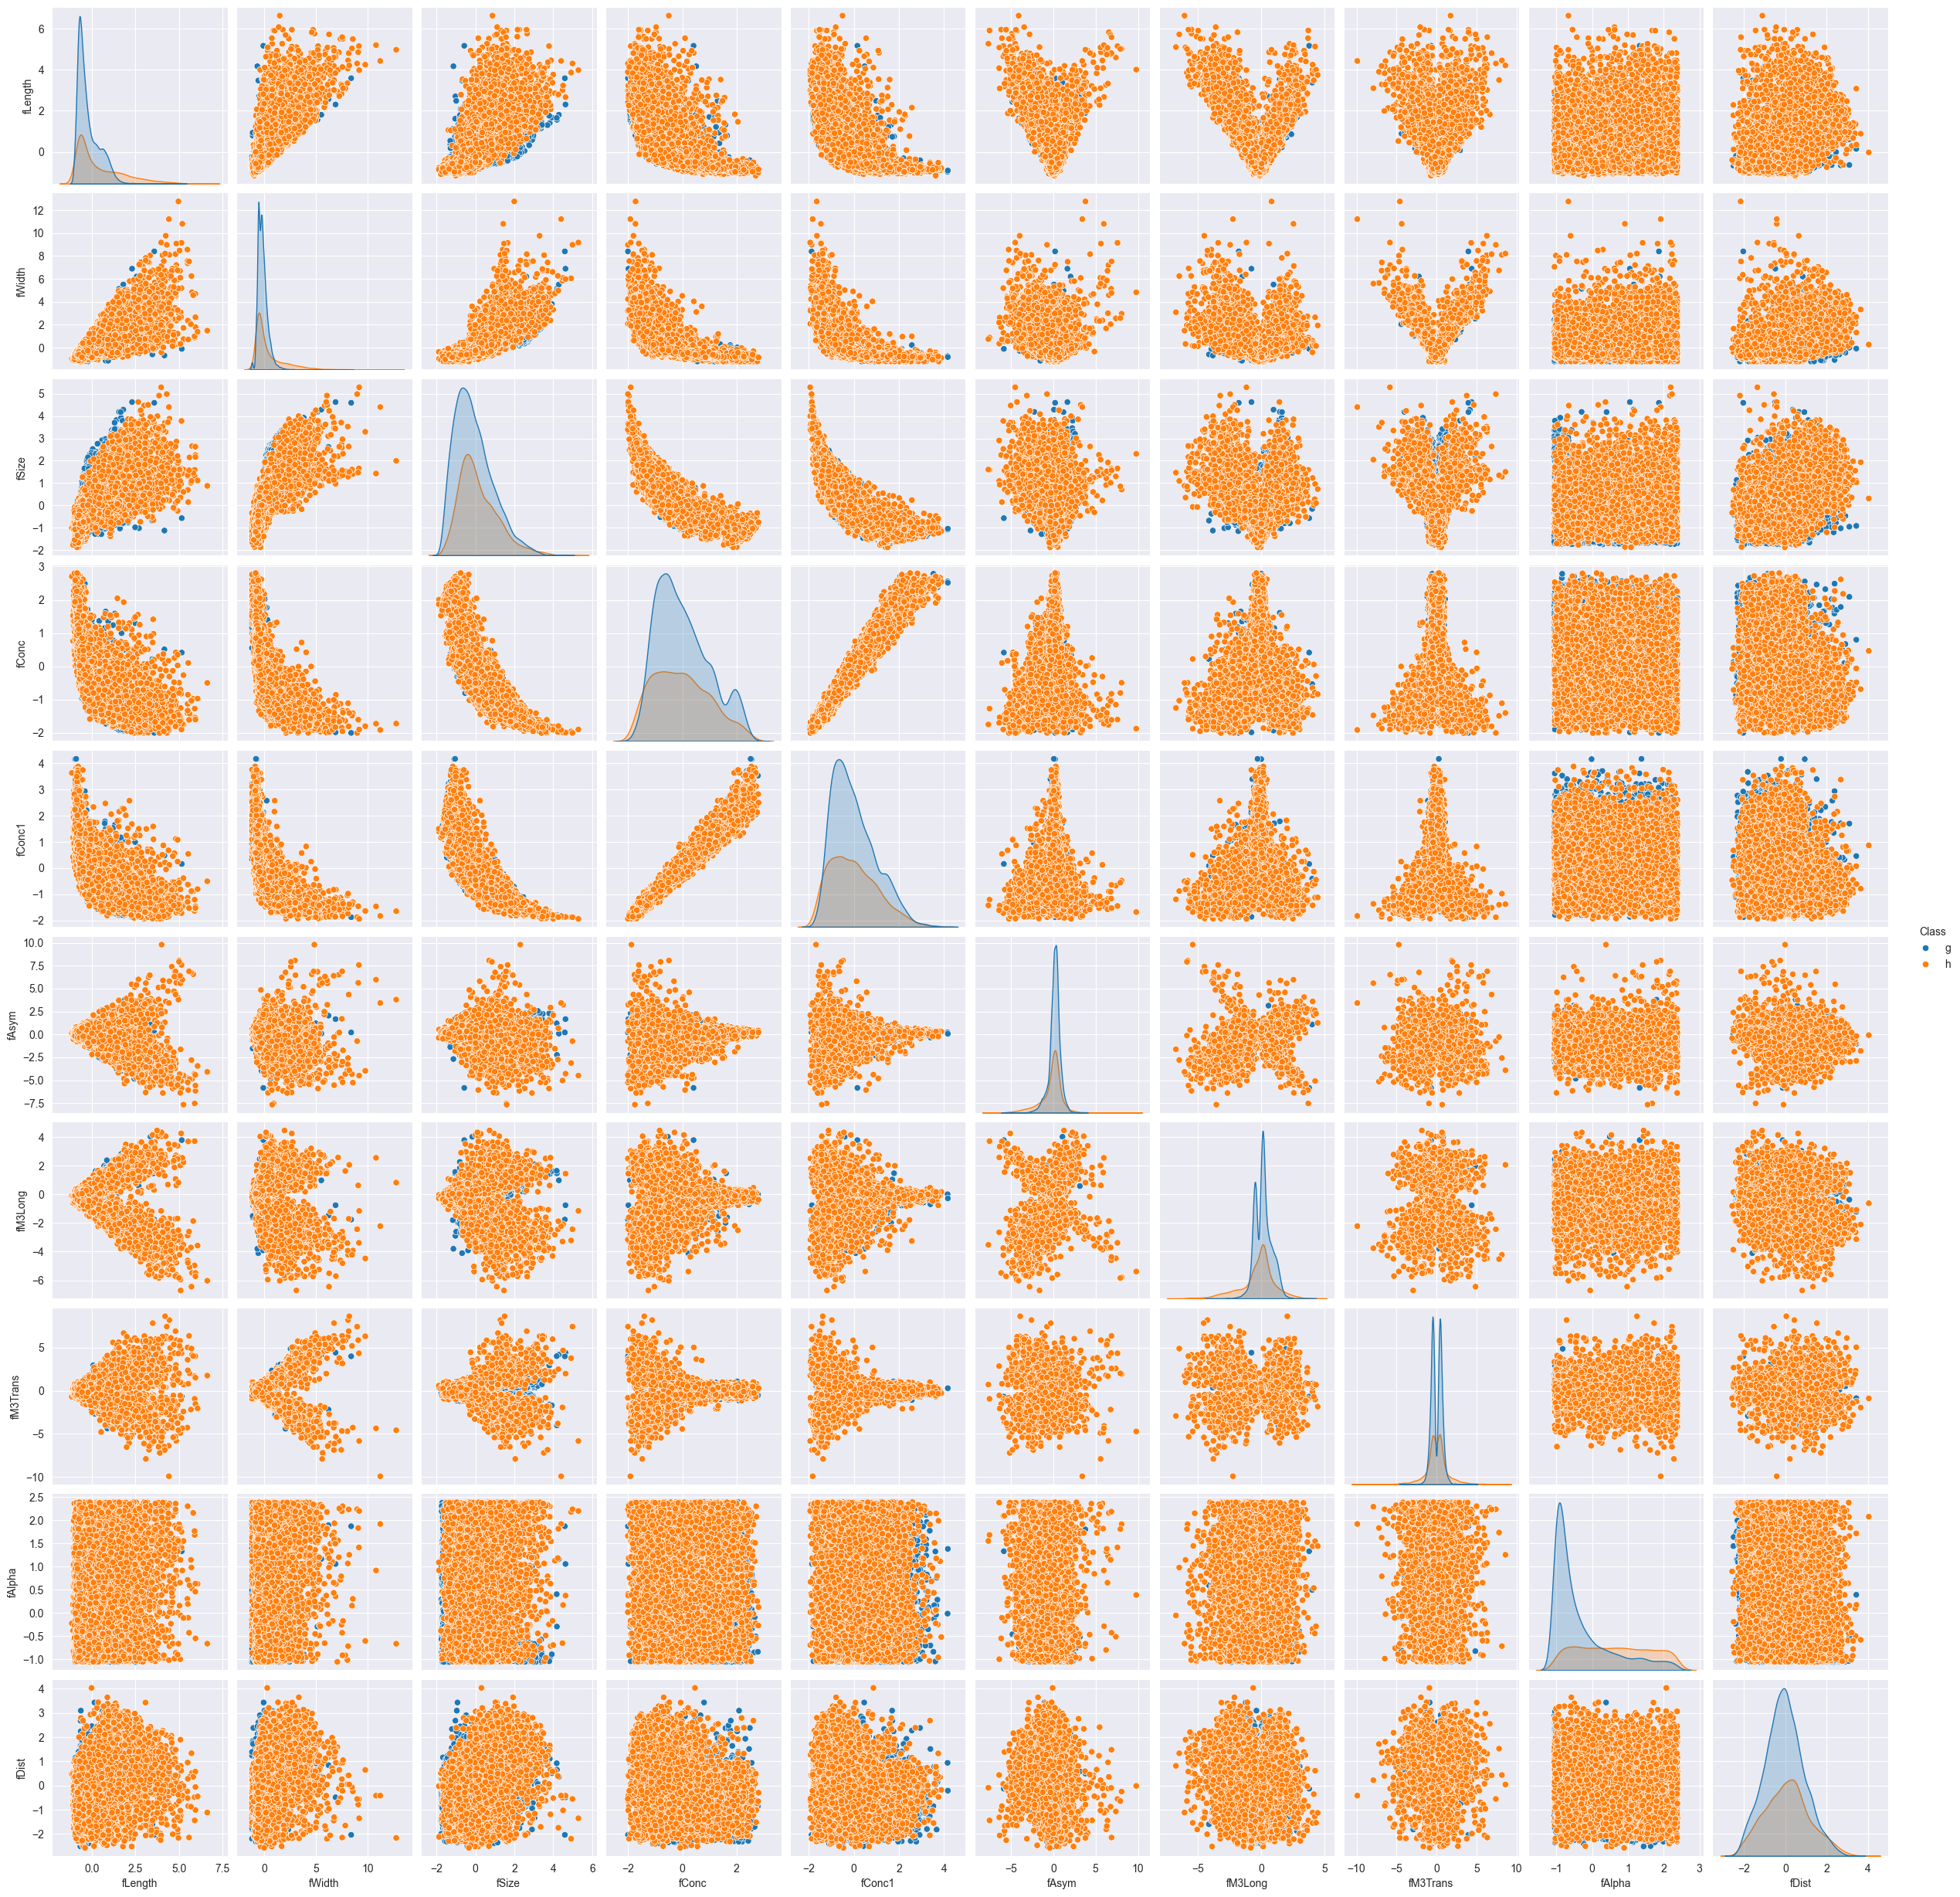

In [25]:
sns.pairplot(X, hue='Class')

# Prueba con árboles
## Dividimos los datos

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2024, stratify=y)

## Decision Tree

In [38]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1338
           1       0.86      0.86      0.86      2466

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



In [35]:
# Pipeline del modelo
pipe_decision_tree = Pipeline([
    ('clf', DecisionTreeClassifier())
])
# Parámetros a probar
param_grid = {
    'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8]
}
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(pipe_decision_tree, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Entrenamiento del modelo
pipe_decision_tree.set_params(**grid_search.best_params_)
pipe_decision_tree.fit(X_train, y_train)
y_pred = pipe_decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

G:\pythonProject\machine_learning_2\.venv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'clf__max_depth': 9, 'clf__max_features': 7, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 3}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1338
           1       0.84      0.93      0.88      2466

    accuracy                           0.84      3804
   macro avg       0.84      0.80      0.81      3804
weighted avg       0.84      0.84      0.83      3804



## CatBoost

In [40]:
# Pipeline del modelo
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
print(classification_report(y_test, y_pred))



Learning rate set to 0.032944
0:	learn: 0.6720725	total: 146ms	remaining: 2m 25s
1:	learn: 0.6512446	total: 153ms	remaining: 1m 16s
2:	learn: 0.6319890	total: 160ms	remaining: 53.2s
3:	learn: 0.6169747	total: 168ms	remaining: 41.8s
4:	learn: 0.6013043	total: 177ms	remaining: 35.1s
5:	learn: 0.5864515	total: 184ms	remaining: 30.5s
6:	learn: 0.5724113	total: 192ms	remaining: 27.2s
7:	learn: 0.5592281	total: 201ms	remaining: 24.9s
8:	learn: 0.5480437	total: 208ms	remaining: 22.9s
9:	learn: 0.5375812	total: 218ms	remaining: 21.6s
10:	learn: 0.5278092	total: 227ms	remaining: 20.4s
11:	learn: 0.5185075	total: 232ms	remaining: 19.1s
12:	learn: 0.5093481	total: 239ms	remaining: 18.2s
13:	learn: 0.5003827	total: 247ms	remaining: 17.4s
14:	learn: 0.4923554	total: 253ms	remaining: 16.6s
15:	learn: 0.4844587	total: 259ms	remaining: 15.9s
16:	learn: 0.4776416	total: 266ms	remaining: 15.4s
17:	learn: 0.4716142	total: 273ms	remaining: 14.9s
18:	learn: 0.4655568	total: 279ms	remaining: 14.4s
19:	learn

## Random Forest

In [41]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1338
           1       0.88      0.94      0.91      2466

    accuracy                           0.87      3804
   macro avg       0.87      0.85      0.86      3804
weighted avg       0.87      0.87      0.87      3804



## Gaussian Naive Bayes

In [34]:
naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred = naive.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.36      0.48      1338
           1       0.73      0.92      0.81      2466

    accuracy                           0.72      3804
   macro avg       0.72      0.64      0.65      3804
weighted avg       0.72      0.72      0.70      3804



## LDA

In [36]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.55      0.63      1338
           1       0.79      0.90      0.84      2466

    accuracy                           0.78      3804
   macro avg       0.77      0.73      0.74      3804
weighted avg       0.77      0.78      0.77      3804



## QDA

In [37]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.47      0.60      1338
           1       0.77      0.94      0.84      2466

    accuracy                           0.77      3804
   macro avg       0.79      0.71      0.72      3804
weighted avg       0.78      0.77      0.76      3804

